# Minitrabalho 2 – "Seis graus de separação"

## 1) Representação dos dados

##### A tarefa inicial consiste em ler e carregar os dados numa estrutura de dados adequada. Isto implica, essencialmente, em concetualizar a relação ator-filme como um grafo.
##### Para a sua implementação, deverá usar como base a classe Graph/Digraph fornecida nos exercícios da Semana 7, ou deve implementar a sua classe Graph de raiz. Não é permitida a utilização de outros módulos Python para a representação de grafos.
##### Com base no conjunto de operações que devem ser suportadas pela sua aplicação (apresentadas na Secção 2), descreva nesta secção os detalhes da estrutura de dados escolhida e o tipo de grafo resultante da sua interpretação do problema. Note que não existe apenas uma "única" representação possível, mas algumas representações podem ser mais/menos eficientes e mais fáceis/difíceis de programar. Você, como desenvolvedor, deve analisar qual será a melhor solução para o problema, mantê-la consistente e fazê-la funcionar. 

In [81]:
import random as rnd
from operator import attrgetter
from collections import deque


In [82]:
# Class Vertice
class Vertex:
    ''' Estrutura de Vértice para um grafo: encapsula um elemento que é o identificador deste nó.
        O elemento deve ser hashable:
        - Um objeto hashable é aquele que pode ser utilizado como uma chave num dicionário Python.
        - Isto inclui strings, números, tuplas, etc.
    '''

    def __init__(self, x, type):
        self._elemento = x
        self._type = type  # 'actor' or 'movie'

    def get_type(self):
        return self._type

    def __hash__(self):
        ''' o valor do elemento é usado como hash para o vértice (o elemento deve ser hashable)'''
        return hash(self._elemento)  # devolve o hash do elemento

    def __str__(self):
        '''Devolve a representação do objeto vértice em string.'''
        return'{0}'.format(self._elemento)

    def __eq__(self, x):
        return x == self._elemento # Deve-se garantir que: se hash(x)==hash(elemento), entao x==elemento

    def vertice(self):
        '''Devolve o elemento guardado neste vértice'''
        return self._elemento


# #### Class Edge
class Edge:
    '''Estrutura de Aresta para um Grafo: (origem, destino)'''

    #! Como é um grafo não pesaddo, nao é necessário pesos
    def __init__(self, u, v):
        self._vertex1 = u   #! vértice origem
        self._vertex2 = v   #! vértice destino

    def __hash__(self):
        # Função que mapeia a aresta a uma posição no dicionário (hash map)
        return hash((self._vertex1, self._vertex2))

    def __str__(self):
        '''Devolve a representação do objeto aresta em string: (origem, destino)'''
        #! Peso retirado
        return'({0},{1})'.format(self._vertex1, self._vertex2)

    def __eq__(self, other):
        # define igualdade de duas arestas (deve ser consistente com a função hash)
        return self._vertex1 == other._vertex1 and self._vertex2 == other._vertex2

    def endpoints(self):
        '''Devolve a tupla (u,v) que indica os vértices antecessor e sucessor.'''
        return (self._vertex1, self._vertex2)

    #! Método do custo retirado

    #! Método showEgde retirado

    # métodos novas
    def get_ant(self):
        return self._vertex1

    def get_suc(self):
        return self._vertex2

    def opposite(self, v):
        '''Indica o vértice oposto ao v neste arco; v tem de ser um dos vértices.'''
        return self._vertex2 if v is self._vertex1 else self._vertex1

In [83]:
class Graph:
    '''
    Representação de um grafo usando dicionários encadeados (nested dictionaries).

    Atributos:
    ----------
    vertices: Dicionário exterior que associa um vértice (Vertex) a um mapa de adjacências (dicionario)
    n: Número de vértices no Grafo
    m: Número de arestas no Grafo
    ----------
'''

    def __init__(self, directed=False):
        '''Construtor: Cria um grafo vazio (dicionário de _vertices).'''
        self._vertices = {}         # dicionário com chave vértice e valor mapa de adjacência
        self._n = 0                 # número de vértices do grafo
        self._m = 0                 # número de arestas do grafo
        self._directed = directed

      
    def _incident_edges(self, v):
        '''Gerador: devolve todas as arestas de um vértice v.'''
        for edge in self._vertices[v].values(): # para todas as arestas incidentes em v:
            yield edge
    
    def __str__(self):
        if self._n == 0:
            ret = "DAA-Graph: <empty>\n"
        else:
            ret = "DAA-Graph:\n"
            for v in self._vertices.keys():
                ret += "vertex "
                ret += str(v) + ": "
                for edge in self._incident_edges(v):
                    ret += str(edge) + "; "
                ret += "\n"
        return ret

    #! Método is_directed retirado

    def order(self):
        '''Ordem de um grafo: a quantidade de vértices no Grafo'''
        return self._n

    def size(self):
        '''Dimensão de um grafo: a quantidade total de arestas do Grafo'''
        return self._m

    def has_node(self, v):
        """Verifica se o vértice v está no grafo."""
        return v in self._vertices

    def has_edge(self, u, v):
        if not self.has_node(u) or not self.has_node(v):
            return False
        else:
            return Vertex(v, 'actor') in self._vertices[Vertex(u, 'actor')].keys() or Vertex(v, 'movie') in self._vertices[Vertex(u, 'movie')].keys()


    def insert_vertex(self, x, type):
        '''Insere e devolve um novo vértice com o elemento x e o tipo type'''
        v = Vertex(x, type)
        self._vertices[v] = {}      # inicializa o dicionário de adjacências deste vértice a vazio
        self._n +=1                 # mais um vértice no grafo
        return v


    #! Peso da aresta retirado
    def insert_edge(self, u, v):
        ''' Cria e insere uma nova aresta entre u e v.
            Se a aresta já existe no grafo, atualiza-se o seu filme. '''
        e = Edge(u, v)

        if not self.has_node(u):
            self.insert_vertex(u)
        if not self.has_node(v):
            self.insert_vertex(v)
        if not self.has_edge(u, v):
            self._m +=1           # atualiza m apenas se a aresta ainda não existir no grafo

        self._vertices[u][v] = e  # coloca v nas adjacências de u
        self._vertices[v][u] = e  # e u nas adjacências de v (para facilitar a procura de todas as arestas incidentes num vértice)



    def degree(self, v, outgoing=True):
        '''Quantidade de arestas originárias ou incidentes no vértice v
           Se for um grafo dirigido, conta as arestas outgoing ou incoming,         #! alterar pois nao é dirigido  
           de acordo com o valor de outgoing (True or False)
        '''
        adj = self._vertices
        if not self._directed:
            count = len(adj[v])
        else:
            count = 0
            for edge in adj[v].values():
                x, y = edge.endpoints()
                if (outgoing and x == v) or (not outgoing and y == v):
                    count += 1
        return count

    def get_edge(self, u, v):
        '''Método interno: Devolve a aresta que liga u a v ou None se não forem adjacentes'''
        edge = self._vertices[u].get(v)     # returns None se não existir aresta entre u e v
        if edge and self._directed: # se é dirigido
            x = edge.endpoints()        # vai confirmar se é o arco u --> v
            if x[1] != v:
                edge = None
        return edge

    def vertices(self):
        '''Devolve um iterável sobre todos os vértices do Grafo'''
        return self._vertices.keys()

    def edges(self):
        '''Devolve o conjunto (set) de todas as arestas do Grafo'''
        result = set()      # avoid double-reporting edges in undirected graph
        for secondary_map in self._vertices.values():
            result.update(secondary_map.values())  # add edges to resulting set
        return list(result)

    def remove_vertex(self, v):
        '''remove o vértice v. Se o vertice não existir, não faz nada.'''
        # remover todas as arestas de [v]
        # remover todas as arestas com v noutros vertices
        # remover o vértice v
        if v in self._vertices.keys():
            lst = [i for i in self.incident_edges(v)]
            for i in lst:
                x, y = i.endpoints()
                self.remove_edge(x,y)
            del self._vertices[v]
            self._n -=1

    def remove_edge(self, u, v):
        '''Remove a aresta entre u e v. Se a aresta não existir, não faz nada.'''
        if  u in self._vertices.keys() and v in self._vertices[u].keys():
            del self._vertices[u][v]
            del self._vertices[v][u]
            self._m -=1

    def has_neighbors(self, v):
        if self.incident_edges(v) != None:
            return True
        else:
            return False

    def incident_edges(self, v, incoming=True):
        '''Gerador: indica todas as arestas incoming de v
           Se for um grafo dirigido e incoming for False, devolve as arestas outgoing
        '''
        for edge in self._vertices[v].values(): # para todas as arestas relativas a v:
            if not self._directed:
                    yield edge
            else:  # senão deve ir procurar em todas as arestas para saber quais entram ou saiem
                x, y = edge.endpoints()
                if (incoming and y == v) or (not incoming and x == v):
                    yield edge

    def get_neighbors(self, v):
        '''Retorna uma lista dos vizinhos do vértice v.'''
        neighbors = []
        for edge in self.incident_edges(v):
            # Para cada aresta incidente no vértice v, adiciona o vértice oposto à lista de vizinhos
            neighbors.append(edge.opposite(v))
        return neighbors

    def is_successor(self, v, x):
        for edge in self.incident_edges(v):
            if edge.get_ant() == x:
                return True
        return False

    def is_predecessor(self, u, v):
      for edge in self.incident_edges(u):
          if edge.get_ant() == v:
              return True
      return False


    def printG(self):
        '''Mostra o grafo por linhas'''
        if self._n == 0:
            print('O grafo está vazio!')
        else:
            print('Grafo orientado:', self._directed)
            for v in self.vertices():
                print('\nvertex ', v, ' grau_in: ', self.degree(v,False), end=' ')# mostra o grau (de saída se orientado)
                for i in self.incident_edges(v):
                    print(' ', i, end=' ')
                if self._directed:          # se orientado, mostrar o grau de saida
                    print('\n \t   grau_out: ', self.degree(v, True), end=' ')
                    for i in self.incident_edges(v, False):    # e mostrar os arcos de saída
                        print(' ', i, end=' ')

    def shortest_path(self, start, end):
        '''Devolve o caminho mais curto entre os vértices start e end usando BFS'''
        queue = deque([(start, [start])])  # fila para BFS, contém tuplas de vértice e caminho
        visited = set([start])  # conjunto de vértices visitados

        while queue:
            (vertex, path) = queue.popleft()  # remove o próximo vértice e caminho da fila
            for neighbor in self.get_neighbors(vertex):  # itera sobre os vizinhos do vértice
                if neighbor not in visited:  # se o vizinho não foi visitado
                    if neighbor == end:  # se o vizinho é o vértice final
                        return path + [end]  # devolve o caminho atual mais o vértice final
                    visited.add(neighbor)  # marca o vizinho como visitado
                    queue.append((neighbor, path + [neighbor]))  # adiciona o vizinho e o novo caminho à fila

        return None  # se não houver caminho entre start e end, devolve None


##### 1.a) [2 valores] Descreva o modelo de grafo que utilizou para concetualizar a relação ator-filme do problema proposto. Liste quais foram os critérios que levaram à sua decisão e as possíveis vantagens e desvantagens da representação usada.
Nota: São listadas abaixo algumas perguntas que devem estar claras na sua resposta:

        • O que são os vértices e as arestas no seu modelo de grafo. Qual foi o critério para esta escolha? Por exemplo, a sua escolha facilita a implementação de alguma operação específica? Ou faz com que as operações fiquem mais eficientes (em relação ao tempo e ao espaço em memória)?

        • A sua representação do problema resulta em que tipo de grafo (não orientado, orientado, pesado, com multiarestas, acíclico, cíclico, bipartido, etc)?
        
        • Que tipo de modificações teve de realizar na classe Graph fornecida (teve de inserir novos atributos/métodos e porquê?); ou como implementou a sua classe Graph?

***Resposta:***

* ***Vértices: Os vértices do grafo podem ser atores sendo que cada ator corresponde a um único vértice no grafo.***

* ***Arestas: As arestas podem representar a relação entre dois atores que atuaram num mesmo filme, isto é, se dois atores participaram no mesmo filme, há uma aresta entre eles. Além disso, as arestas guardam os filmes em que os atores co-atuaram***

* ***Tipo de grafo: O grafo resultante é um grafo não orientado e não pesado. É não orientado porque a relação de participação é não é direcional - se o ator A atuou com o ator B num filme, então o ator B também atuou com o ator A. É não pesado porque todas as arestas têm o mesmo peso - a participação num filme.***

* ***Modificações na classe Graph: Há a necessidade de adicionar um método que calcule o caminho mais próximo entre dois vértices, que será útil para determinar o "número de Bacon" de um ator. Além disso, devemos adicionar um método para obter todos os vértices adjacentes a um vértice em específico, o que é útil quando há necessidade de explorar o grafo.***

##### 1.b) [1,5 valores] Implemente uma função auxiliar que irá construir um grafo (do tipo Graph implementado) a partir dos dados de um ficheiro .txt fornecido. A função deve receber como argumento o nome do ficheiro e devolver um objeto do tipo Graph.
Nota 1: Cada linha do ficheiro fornecido apresenta o nome de um filme seguido de uma lista dos atores
que participaram no filme. Para separar os nomes que aparecem numa linha, o caracter '/' é utilizado
como delimitador.

Harry Potter and the Chamber of Secrets (2002)/Davis, Warwick (I)/Knight, Tom (I)/…

Harry Potter and the Goblet of Fire (2005)/Gambon, Michael/Claydon, Steve (II)/…

Harry Potter and the Prisoner of Azkaban (2004)/Phelps, James (I)/Murray, Devon/…

…

São anexadas duas bases de dados ao enunciado do projeto:

    • small_dataset.txt: Contém a lista de filmes classificados no IMBD em 2011: 4.527 filmes e 122.406 atores (~3,5MB). Deve ser utilizada para realizar testes enquanto implementa a sua API.

    • large_dataset.txt: Contém todos os filmes do IMBD em 2011: 285.460 filmes e 933.864 atores (~60MB). Deve ser usada para gerar os resultados dos testes definidos na Secção 3. Note que, para conseguir testar com esta base de dados, terá de ter disponível um espaço de memória RAM suficiente, uma vez que o grafo irá ser todo carregado para a memória.
    
Nota 2: Se achar mais fácil ter esta função implementada na classe HollywoodOracle (Secção 2), é livre
de o fazer.



In [84]:
from collections import deque

def build_graph_from_file(filename):
    # Cria um grafo vazio
    graph = Graph()

    # Abre o arquivo para leitura
    with open(filename, 'r', encoding='utf-8') as file:
        # Lê cada linha do arquivo
        for line in file:
            # Divide a linha em filme e lista de atores
            movie, *actors = line.strip().split('/')
            
            # Verifica se o filme já existe no grafo, se não, insere
            if not graph.has_node(movie):
                graph.insert_vertex(movie, 'movie')

            # Para cada ator, insere um vértice e uma aresta entre o ator e o filme
            for actor in actors:
                # Verifica se o ator já existe no grafo, se não, insere
                if not graph.has_node(actor):
                    graph.insert_vertex(actor, 'actor')
                
                # Insere a aresta entre o ator e o filme
                graph.insert_edge(actor, movie)

    return graph

In [85]:
# #Test build_graph_from_file
# graph = build_graph_from_file('large_dataset_utf8.txt')

## 2) API HollywoodOracle

##### A sua aplicação terá de suportar as operações listadas na API HollywoodOracle apresentada abaixo.

##### 2.a) [1,5 valores] Descreva a estrutura de dados que utilizou para implementar a sua API. Apresente uma análise informal do espaço em memória total utilizado pela sua aplicação. Mais especificamente, indique quanto espaço de memória os atributos da sua classe HollywoodOracle ocupam em relação ao número de filmes e atores/atrizes que existem na base de dados analisada.

Nota: Em relação ao espaço em memória, deve também apresentar uma estimativa do espaço real
ocupado pela classe. Para isso, pode utilizar a função getsizeof() do módulo Python sys, e verificar o
tamanho dos atributos do grafo construído e também de qualquer outro atributo que componha a sua
implementação da classe HollywoodOracle.

##### 2.b) [12 valores] Implemente cada uma das operações listadas na API HollywoodOracle abaixo. Para cada operação, deve apresentar uma análise informal da sua complexidade em relação ao tempo e ao espaço extra de memória utilizado (em relação ao número de filmes/atores).

Nota 1: Pode haver vários caminhos de distância mínima entre o “centro do universo” e um ator qualquer. Neste trabalho, será suficiente apresentar um destes caminhos.

Nota 2: Comece por testar cada um dos métodos com um ficheiro que tenha apenas 5-10 filmes antes de realizar testes na base de dados small_dataset.txt, para ter a certeza de que a sua resolução está
correta. No relatório, apresente os resultados dos testes que foram realizados para cada método (exceto all_movies() e all_actors()) usando a base de dados small_dataset.txt.

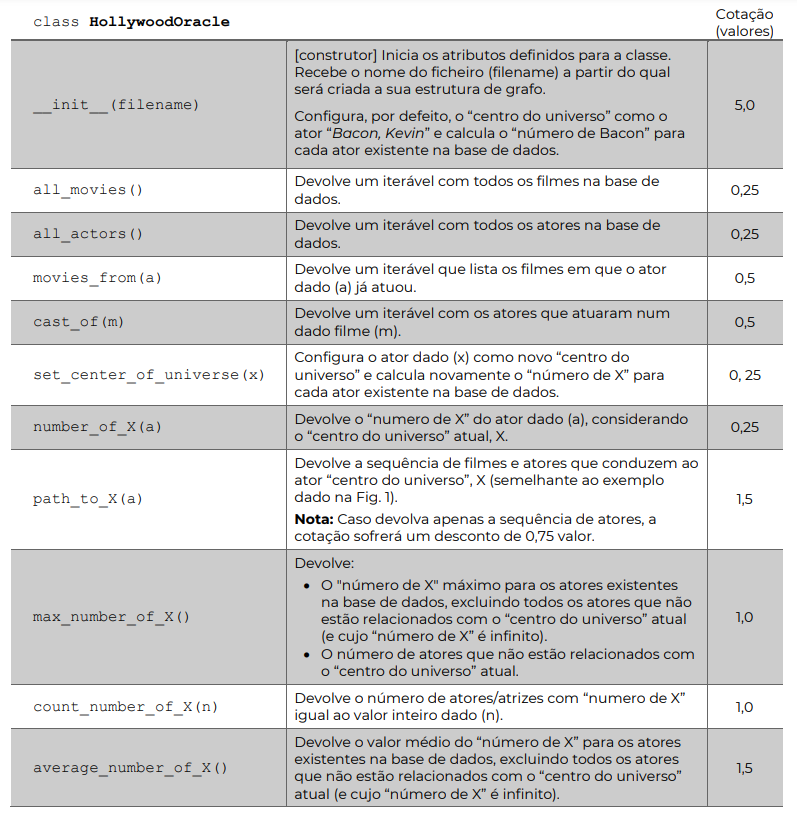

In [86]:
#Correr para ver tabela presente no ponto 2.b) do enunciado
from PIL import Image
from IPython.display import display
img = Image.open('HollywoodOracle.png')
display(img)

In [87]:
class HollywoodOracle:

    def __init__(self, filename):
        # Obtém o grafo a partir do arquivo
        self.graph = build_graph_from_file(filename)
        self.center_of_universe = "Bacon, Kevin"

    def all_actors(self):
        '''Devolve uma lista de todos os atores no grafo.'''
        actors = []
        for vertex in self.graph.vertices():
            if vertex.get_type() == 'actor':
                actors.append(vertex.vertice())
        return actors

    def get_all_movies(self):
        '''Devolve uma lista de todos os filmes no grafo.'''
        movies = []
        for vertex in self.graph.vertices():
            if vertex.get_type() == 'movie':
                movies.append(vertex.vertice())
        return movies
    





In [90]:
# Testando a classe HollywoodOracle
oracle = HollywoodOracle('small_dataset_utf8.txt')

# Testar o método all_actors
print(len(oracle.all_actors()))

# Testar o método get_all_movies
print(len(oracle.get_all_movies()))



122406
4527


## 3) Testes

##### 3.1) [1 valor] Usando a base de dados large_dataset.txt, implemente um script/função que utiliza a API HollywoodOracle e apresenta um histograma do número de atores com o mesmo “número de Bacon” (paratodos os “números de Bacon” diferentes de infinito). Considere como o “centro do universo” o ator “Bacon, Kevin”.

Nota 1: Para além do gráfico, imprima os resultados encontrados, ou seja, imprima o número de atores
com cada “número Bacon” possível (numa linha diferente).

Nota 2: Imprima também “número de Bacon” médio encontrado (ou seja, o resultado da operação
average_number_of_X()).


##### 3.2) [1 valor] Usando a base de dados large_dataset.txt, implemente um script/função que utiliza a API HollywoodOracle e apresenta um gráfico do “número de X” médio considerando como o “centro do universo” cada um dos 20 atores mais populares de Hollywood nos anos 2000, segundo o IMBD. Ou seja, a função average_number_of_X deve ser executada para cada um dos 20 atores de modo a obter o seu “número médio de X”. A lista de atores mais populares encontra-se no ficheiro top20imbd.csv anexado.

Nota 1: Para além do gráfico, imprima os resultados, ou seja, imprima os valores do “número de X” médio de cada um dos 20 atores (numa linha diferente).

Nota 2: Se, por qualquer razão, não for possível executar este teste na base de dados large_dataset.txt, deve justificar a razão do problema e, em alternativa, executar o teste utilizando
o ficheiro small_dataset.txt. Só serão aceites justificações sustentadas por factos (por exemplo, capturas de ecrã do erro e/ou tempo de execução).

##### 3.3) [1 valor] Se a teoria dos seis graus de separação for verdadeira para Hollywood, isso implicaria que a maioria dos atores terá um “número de X” de 6 ou menos, o que significa que o “número de X” médio seria menor do 6. Para testar esta teoria, implemente um script/função que utiliza a API HollywoodOracle com a base de dados small_dataset.txt, e apresenta um gráfico do “número de X” médio considerando como o “centro do universo” 1000 atores selecionados de forma aleatória da base de dados.

Nota: Este teste pode demorar bastante tempo a ser concluído. Por esta razão, sugerimos que escreva os resultados num ficheiro para que seja possível recuperá-los caso a execução seja interrompida.

## 4) Questões Éticas

##### Tente resolver os problemas apenas com os integrantes do seu grupo antes de colaborar. Escreva as suas respostas por suas próprias palavras. Nunca deve partilhar o ficheiro fonte com as suas soluções com integrantes de outros grupos.

##### 4.a) Se colaborou com alguém fora do seu grupo, indique aqui os respetivos nomes.

##### 4.b) Deve citar todas as fontes que utilizou fora do material da UC.